### **Optimizaing Power Generation in Ontario:**

*MGSC 662: Group Project*

Team members: Ali Farhat - Juliana Hubacova - Karen Bou Daou - Julian Oppedisano - Sahil Negi

In [362]:
import gurobipy as gb
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

**Step 1:**

We began by loading the Ontario market demand dataset, which contains hourly demand data for the entire year. Next, we filtered the dataset to extract data specifically for January 1, 2024, using the year, month, and day as criteria. From this filtered data, we created a dictionary mapping each hour of the day to its corresponding demand value and a set representing the 24 hours of the day. This step provides the necessary hourly demand data input for the optimization model.

In [363]:
ontario_demand_data = pd.read_csv("ONTARIO DEMAND CLEAN.csv")

# Filter the data for January 1, 2024
df_jan_1 = ontario_demand_data[
    (ontario_demand_data['YEAR'] == 2024) & 
    (ontario_demand_data['MONTH'] == 1) & 
    (ontario_demand_data['DAY'] == 1)
]

# Extract hourly demand as a dictionary (Hour -> Demand)
d = df_jan_1.set_index('HOUR')['LOAD'].to_dict()

# Extract the set of hours in the day
H = set(d.keys())

# Display the results
print("Demand Dictionary:", d)
print("Set of Hours:", H)

Demand Dictionary: {1: 14482, 2: 14180, 3: 13722, 4: 13637, 5: 13697, 6: 13787, 7: 14055, 8: 14481, 9: 14708, 10: 14890, 11: 15240, 12: 15564, 13: 15920, 14: 16072, 15: 16339, 16: 16538, 17: 17147, 18: 17805, 19: 17525, 20: 17261, 21: 16822, 22: 16303, 23: 15410, 24: 14694}
Set of Hours: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}


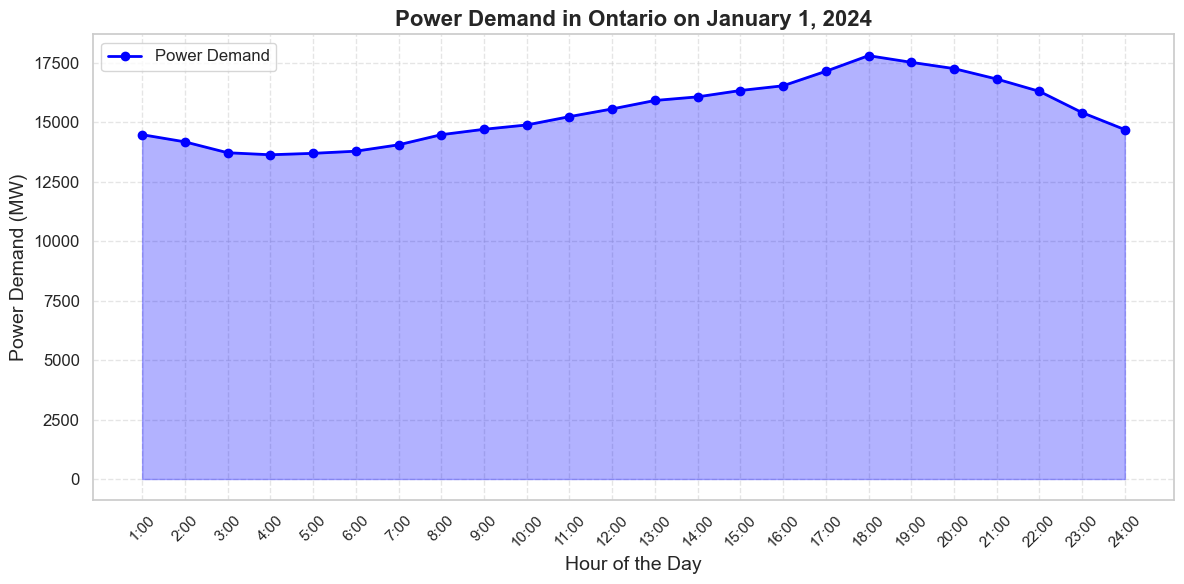

In [364]:
# Let's visualize the demand per hour in Ontario on Januray 1st, 2024
sns.set_theme(style = "whitegrid")

hours = list(range(1, 25))
demand = [d[h] for h in hours]

# Plot the demand vs. hours
plt.figure(figsize=(12, 6))
plt.plot(hours, demand, marker = 'o', linestyle = '-', linewidth = 2, markersize = 6, label = 'Power Demand', color = 'blue')
plt.fill_between(hours, demand, alpha = 0.3, color = 'blue')
plt.title("Power Demand in Ontario on January 1, 2024", fontsize = 16, weight = 'bold')
plt.xlabel("Hour of the Day", fontsize = 14)
plt.ylabel("Power Demand (MW)", fontsize = 14)
plt.xticks(ticks=hours, labels=[f"{h}:00" for h in hours], rotation = 45)
plt.yticks(fontsize = 12)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend(fontsize = 12, loc = "upper left")
plt.tight_layout()
plt.show()

# Power usage is higher in the evenings. The highest is at 6:00 pm with a demand of 17805 MW.

**Step 2:**

In this step, we prepared the dataset for optimization by focusing on actual and potential outputs. **Capability** represents the maximum potential output for nuclear, hydro, gas, and biofuel generators, while **Available Capacity** serves the same purpose for wind and solar generators, accounting for outages and derates. **Output** is the actual energy produced, and **Forecast** estimates potential output for wind and solar based on weather conditions. We dropped rows labeled "Forecast" since they are estimates, not actual or potential values. Additionally, we renamed "Available Capacity" to "Capability" for wind and solar generators to standardize terminology across all types. The data description allows for **Output** to exceed **Capability** due to real-time IESO dispatch adjustments, favorable conditions, or metering variances. These changes ensure consistency and simplify the dataset for analysis.

In [365]:
gen_data = pd.read_csv("Jan_GenOutputCapabilityMonth_2024.csv")

gen_data.head()

# Replace missing values by 0
gen_data = gen_data.fillna(0)

# Drop rows where Measurement is "Forecast"
gen_cleaned_data = gen_data[gen_data['Measurement'] != 'Forecast']

# Rename "Available Capacity" to "Capability" in the Measurement column
gen_cleaned_data['Measurement'] = gen_cleaned_data['Measurement'].replace('Available Capacity', 'Capability')

output_file_path = 'Cleaned_Generator_Data.xlsx'
gen_cleaned_data.to_excel(output_file_path, index=False)

output_file_path
gen_cleaned_data.head()

C:\Users\User\AppData\Local\Temp\ipykernel_32208\433203868.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Delivery Date,Generator,Fuel Type,Measurement,Hour 1,Hour 2,Hour 3,Hour 4,Hour 5,Hour 6,...,Hour 15,Hour 16,Hour 17,Hour 18,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24
0,1/1/2024,ABKENORA,HYDRO,Capability,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
1,1/1/2024,ABKENORA,HYDRO,Output,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
2,1/1/2024,ADELAIDE,WIND,Capability,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,60
4,1/1/2024,ADELAIDE,WIND,Output,13,25,27,24,25,30,...,6,21,26,16,10,9,8,11,9,8
5,1/1/2024,AGUASABON,HYDRO,Capability,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24


**Step 3:**

We structured the cleaned generator dataset to support the optimization model by creating a set of all unique generators, enabling streamlined handling of generator-specific variables. A subset of nuclear generators was extracted to account for their unique operational constraints, such as minimum output levels or always-on requirements. Additionally, a dictionary mapping each generator to its fuel type was developed, allowing for efficient retrieval of fuel-specific parameters like costs and capacities. These steps ensure the data is organized for seamless integration into the model.

In [366]:
pp_data = pd.read_excel("Cleaned_Generator_Data.xlsx")

# Extract the set of all unique generator names
unique_generators = set(pp_data['Generator'].unique())

# Extract the set of nuclear generators
nuclear_generators = set(
    pp_data[pp_data['Fuel Type'] == 'NUCLEAR']['Generator'].unique()
)

# Dictionary mapping each generator to its fuel type
fuel_type_dict = pp_data.set_index('Generator')['Fuel Type'].to_dict()

print("Unique Generators:", unique_generators, len(unique_generators))
print("Nuclear Generators:", nuclear_generators, len(nuclear_generators))
print("Fuel Type Dictionary (Preview):", list(fuel_type_dict.items())[:5]) # Debugging purposes


Unique Generators: {'MACKAYGS', 'ROMNEY', 'PORTLANDS-G1', 'KIPLING', 'DECEWND1', 'MCLEANSMTNWF-LT.AG_T1', 'SITHE GOREWAY-G15', 'RAILBEDWF-LT.AG_SR', 'CEDAR POINT 2', 'ALEXANDER', 'BRUCEB-G8', 'ATIKOKAN-G1', 'EAST LAKE', 'LOWER WHITE RIVER', 'PICKERINGA-G1', 'HARMON 2', 'HENVEY NORTH', 'PORTALMA-T1', 'STCLAIRCGS', 'OTTERRAPIDS', 'HARRIS', 'PICKERINGB-G5', 'PINEPORTAGE', 'BELLE RIVER', 'NPKIRKLAND-G1-G5', 'COMBER', 'DILLON', 'BRUCEA-G3', 'YORKCGS-G1', 'BRUCEA-G1', 'KIPLING 2', 'TBAYBOWATER CTS', 'AGUASABON', 'LOWERNOTCH', 'MANITOUFALLS', 'NORTHBAYGS', 'NPIROQFALLS', 'CARIBOUFALLS', 'NANTICOKE SOLAR', 'KINGSBRIDGE', 'EAST WINDSOR-G2', 'NORTHLAND POWER SOLAR FACILITIES', 'TAWINDSOR', 'TUNISGS', 'BRUCEA-G4', 'GREENFIELD ENERGY CENTRE-G3', 'LENNOX-G1', 'HOLINGSWTH', 'BORNISH', 'SITHE GOREWAY-G12', 'AMHERST ISLAND', 'NAGAGAMI', 'PICKERINGA-G4', 'ABKENORA', 'GRANDWF', 'GTAA-G3', 'STONE MILLS SF', 'NAPANEE-G2', 'SITHE GOREWAY-G13', 'ADELAIDE', 'PETER SUTHERLAND SR', 'KAPGS', 'BECK1', 'SUMMERHAV

**Step 4:**

We created a dictionary mapping each unique generator to its capability, defined as the value in the "Hour 1" column of the "Capability" rows. We chose Hour 1 because the capability values across all 24 hours were identical, reflecting the fixed maximum potential output of each generator, which is logical for their design. To ensure consistency, we restricted the dataset to January 1, 2024, as this represents the pre-upgraded state of the generators before any capacity enhancements made later in the year. This approach ensures that the baseline capabilities are uniform and unaltered, aligning with the project's objective to analyze the original generator capacities.

In [367]:
# Filter the dataset for the date 1/1/2024
filtered_data = pp_data[pp_data['Delivery Date'] == '1/1/2024']

# Dictionary for each unique generator and its capability (value in 'Hour 1' column for 'Capability' row)
gen_capability_dict = (
    filtered_data[filtered_data['Measurement'] == 'Capability']
    .set_index('Generator')['Hour 1']
    .to_dict()
)

print(gen_capability_dict, len(gen_capability_dict))

{'ABKENORA': '11', 'ADELAIDE': '60', 'AGUASABON': '24', 'ALEXANDER': '65', 'AMARANTH': '199', 'AMHERST ISLAND': '74', 'APIROQUOIS': '100', 'ARMOW': '180', 'ARNPRIOR': '82', 'ATIKOKAN-G1': '215', 'AUBREYFALLS': '146', 'BARRETT': '155', 'BECK1': '546', 'BECK2': '1578', 'BECK2 PGS': '87', 'BELLE RIVER': '100', 'BLAKE': '60', 'BORNISH': '73', 'BOW LAKE': '20', 'BOW LAKE 2': '40', 'BRIGHTON BEACH': '565', 'BRUCEA-G1': '822', 'BRUCEA-G2': '828', 'BRUCEA-G3': '0', 'BRUCEA-G4': '816', 'BRUCEB-G5': '817', 'BRUCEB-G6': '817', 'BRUCEB-G7': '817', 'BRUCEB-G8': '780', 'CALSTOCKGS': '38', 'CAMERONFALLS': '96', 'CANYON': '209', 'CARDINAL': '184', 'CARIBOUFALLS': '94', 'CARMICHAEL': '19', 'CEDAR POINT 2': '100', 'CHATSFALLS': '72', 'CHENAUX': '158', 'CLERGUE': '50', 'COMBER': '166', 'CRYSLER': '96', 'DA WATSON': '80', 'DARLINGTON-G1': '0', 'DARLINGTON-G2': '855', 'DARLINGTON-G3': '870', 'DARLINGTON-G4': '0', 'DECEWFALLS': '74', 'DECEWND1': '16', 'DESJOACHIMS': '322', 'DESTEC': '120', 'DILLON': '78', '

C:\Users\User\AppData\Local\Temp\ipykernel_32208\25881720.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\User\AppData\Local\Temp\ipykernel_32208\25881720.py:19: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



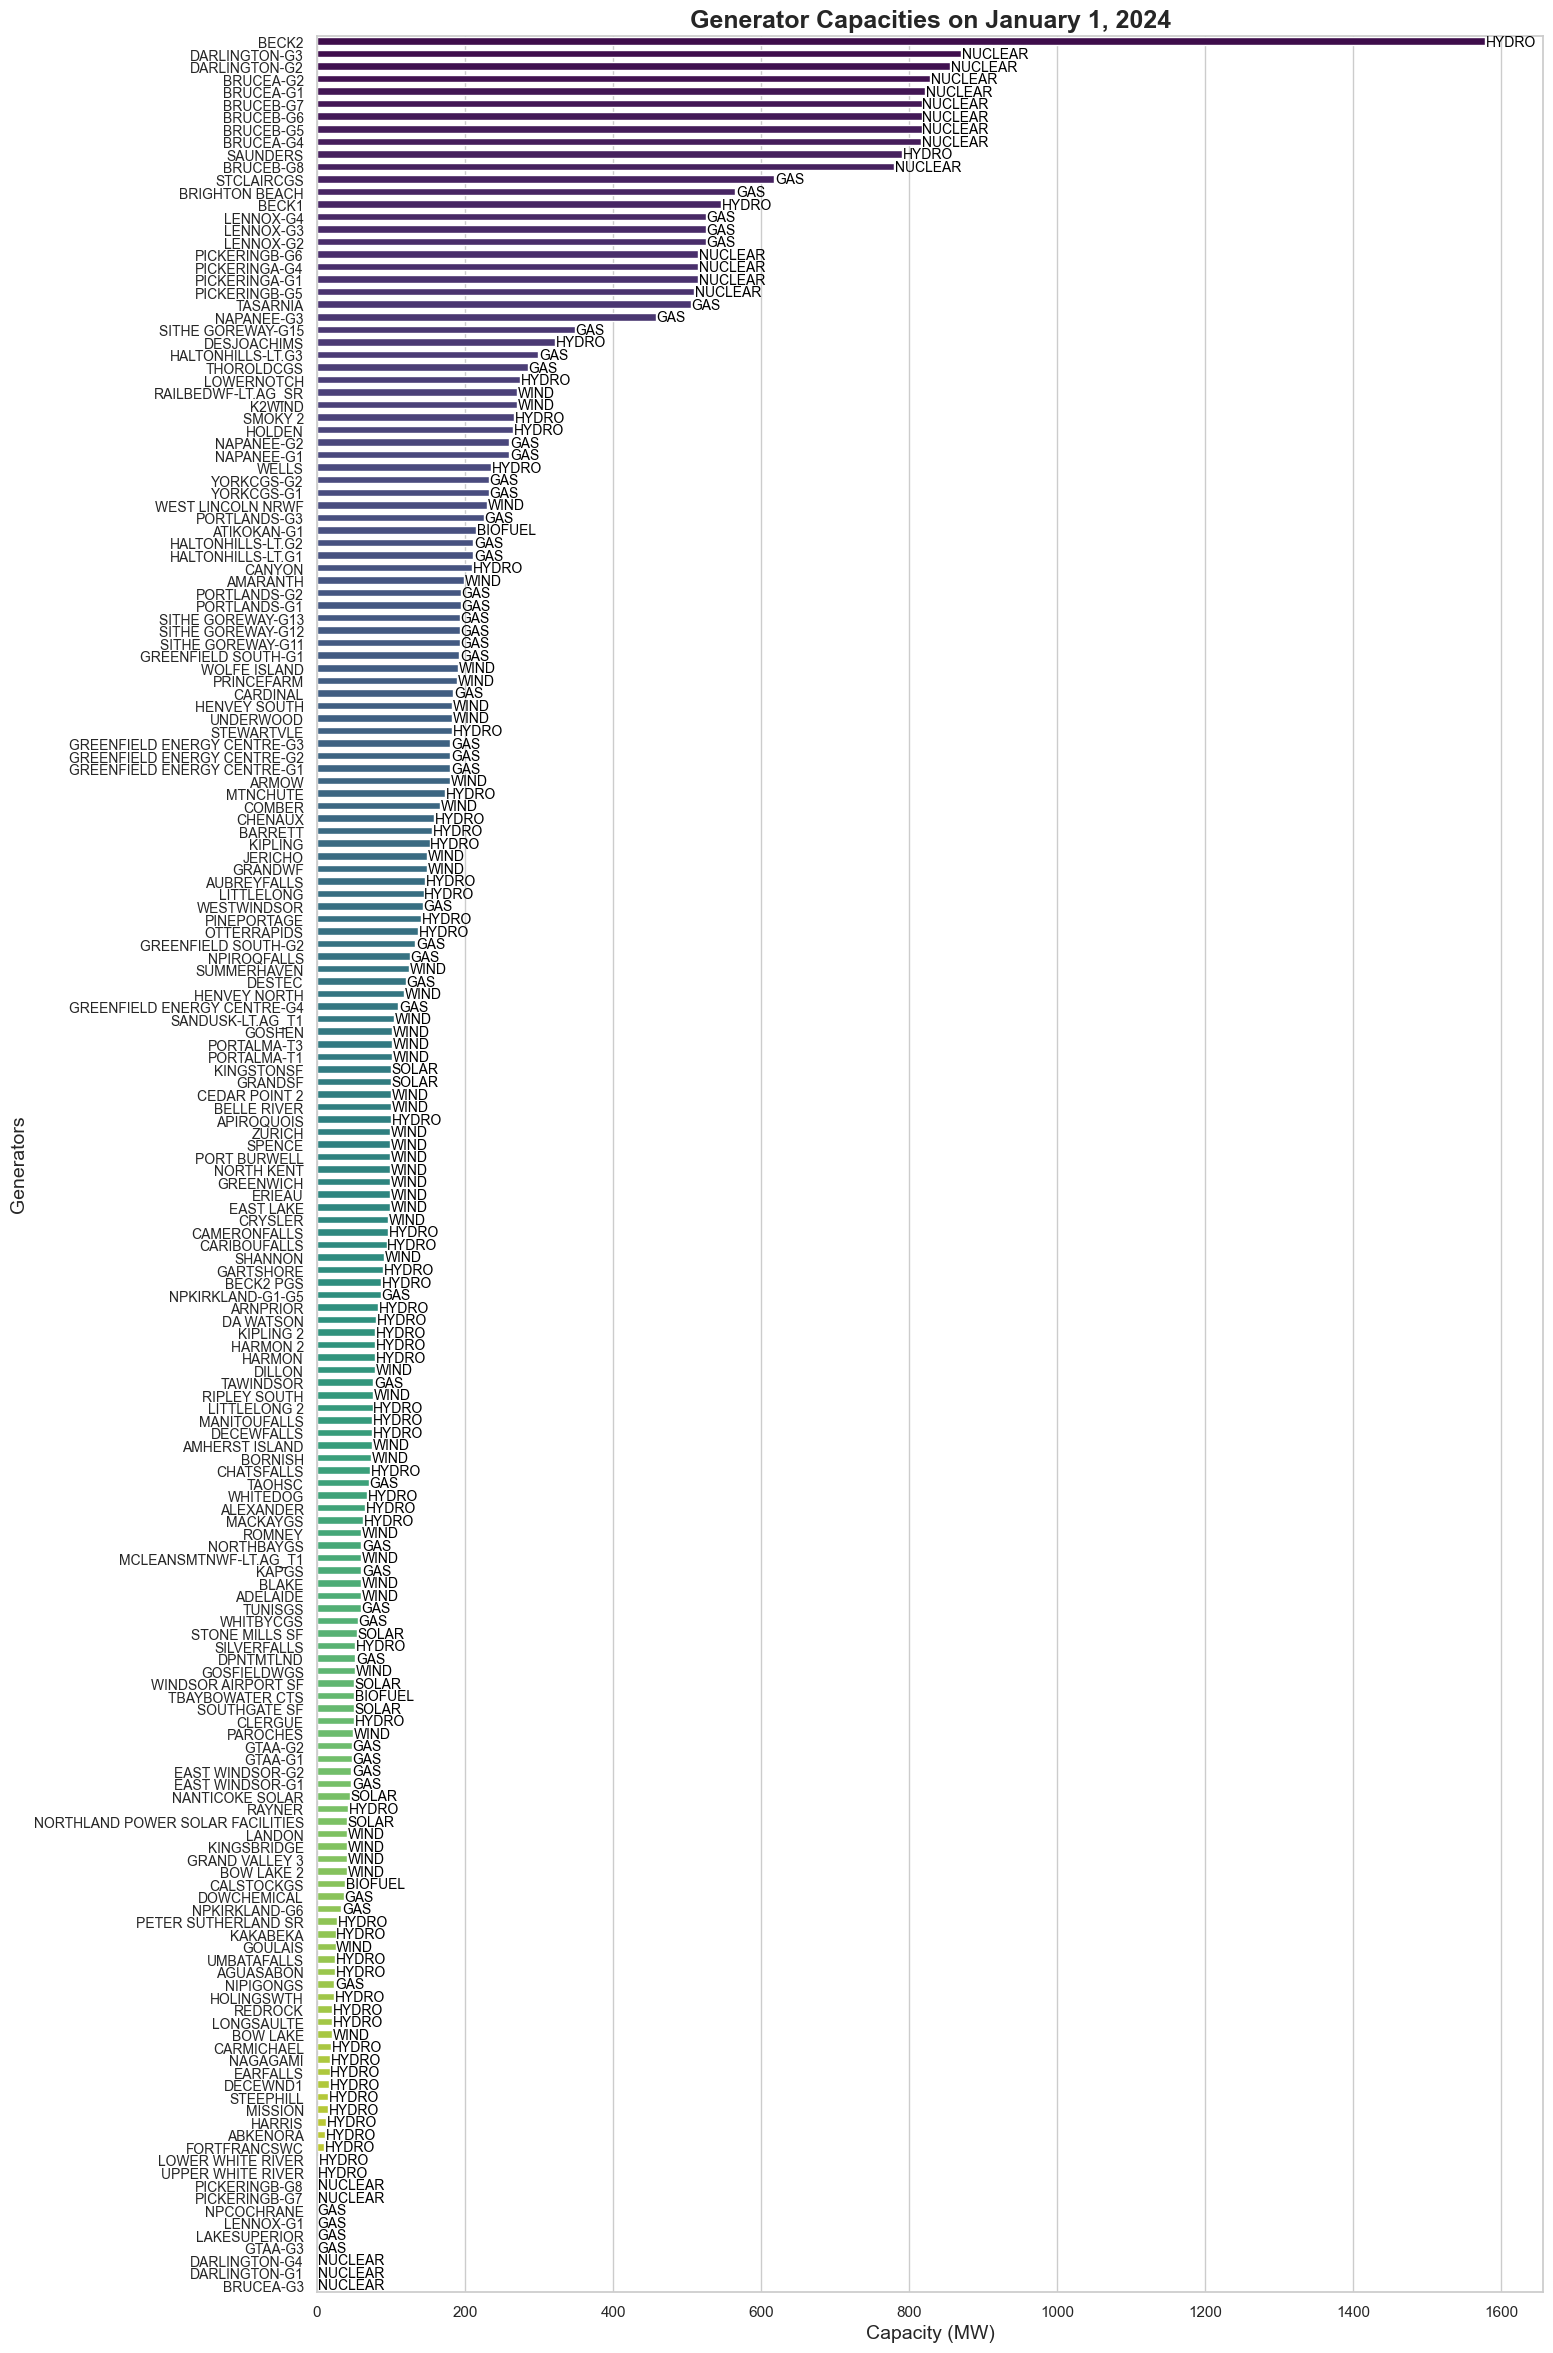

In [368]:
# Horizontal Bar plot showing the capacities of the generators in Ontario

capacities = [float(value) for value in gen_capability_dict.values()]
generator_names = list(gen_capability_dict.keys())
fuel_types = [fuel_type_dict[gen] for gen in generator_names]

sorted_generators = sorted(zip(capacities, generator_names, fuel_types), reverse=True)
sorted_capacities, sorted_names, sorted_fuel_types = zip(*sorted_generators)

sns.set_theme(style = "whitegrid")

plt.figure(figsize = (16, 24))
capacity_plot = sns.barplot(x = sorted_capacities, y = sorted_names, palette = "viridis", orient = 'h')
for bar in capacity_plot.patches:
    bar.set_height(0.6)
capacity_plot.set_title("Generator Capacities on January 1, 2024", fontsize = 18, weight = 'bold')
capacity_plot.set_xlabel("Capacity (MW)", fontsize = 14)
capacity_plot.set_ylabel("Generators", fontsize = 14)
capacity_plot.set_yticklabels(sorted_names, fontsize = 10)
for i, (value, fuel) in enumerate(zip(sorted_capacities, sorted_fuel_types)):
    plt.text(value + 1, i, f"{fuel}", ha = 'left', va = 'center', fontsize = 10, color = "black")

plt.tight_layout(pad = 2.0)
plt.show()

Obviously, Ontario relies the most on Hydro and Nuclear plants as shown in the horizontal bar plot.

**Step 5: Conditions:**

**A) Nuclear power plants:** 

They are designed to operate continuously at high output levels due to their technical and economic characteristics. When a nuclear plant is operational, it typically must generate in between 50 to 100% of its capability. This requirement stems from several factors:

1. Technical Constraints: Nuclear reactors are optimized for steady-state operation. Operating at low power levels can lead to challenges in maintaining reactor stability and control. Frequent or significant power adjustments can introduce thermal stresses, potentially affecting the integrity of reactor components. According to the Nuclear Energy Agency, modern Generation III/III+ reactors are designed for load-following capabilities, allowing for daily load cycling between 50% and 100% of their rated power, with ramp rates of 3-5% per minute. (https://www.oecd-nea.org/upload/docs/application/pdf/2021-12/technical_and_economic_aspects_of_load_following_with_nuclear_power_plants.pdf)

2. Economic Considerations: The cost structure of nuclear power is characterized by high capital investment and relatively low operational costs. Fuel expenses constitute a small fraction of the total generating cost. Therefore, operating at higher capacity factors is economically advantageous, as it maximizes the return on investment. Operating at reduced power levels decreases the plant's efficiency and increases the cost per unit of electricity generated.(https://www.oecd-nea.org/upload/docs/application/pdf/2021-12/technical_and_economic_aspects_of_load_following_with_nuclear_power_plants.pdf)

3. Grid Stability and Reliability: Nuclear plants provide a stable and continuous power supply, contributing to grid reliability. Maintaining a high output ensures a consistent base load, which is essential for balancing supply and demand in the electrical grid. Sudden reductions in nuclear power output can necessitate rapid compensation from other sources, potentially compromising grid stability.

For the sake of this project, we will make a general assumption for all of the available nuclear power plants in Ontario that they need to generate at least 75% of ther maximum capacity. However, for the rest of the plants we set this minimum limit to 1%.

In [369]:
m = {}
for i in unique_generators:
    if i in nuclear_generators:
        m[i] = 0.75  # 75% minimum for nuclear generators
    else:
        m[i] = 0.01  # 1% minimum for other generators
print(m, len(m))

{'MACKAYGS': 0.01, 'ROMNEY': 0.01, 'PORTLANDS-G1': 0.01, 'KIPLING': 0.01, 'DECEWND1': 0.01, 'MCLEANSMTNWF-LT.AG_T1': 0.01, 'SITHE GOREWAY-G15': 0.01, 'RAILBEDWF-LT.AG_SR': 0.01, 'CEDAR POINT 2': 0.01, 'ALEXANDER': 0.01, 'BRUCEB-G8': 0.75, 'ATIKOKAN-G1': 0.01, 'EAST LAKE': 0.01, 'LOWER WHITE RIVER': 0.01, 'PICKERINGA-G1': 0.75, 'HARMON 2': 0.01, 'HENVEY NORTH': 0.01, 'PORTALMA-T1': 0.01, 'STCLAIRCGS': 0.01, 'OTTERRAPIDS': 0.01, 'HARRIS': 0.01, 'PICKERINGB-G5': 0.75, 'PINEPORTAGE': 0.01, 'BELLE RIVER': 0.01, 'NPKIRKLAND-G1-G5': 0.01, 'COMBER': 0.01, 'DILLON': 0.01, 'BRUCEA-G3': 0.75, 'YORKCGS-G1': 0.01, 'BRUCEA-G1': 0.75, 'KIPLING 2': 0.01, 'TBAYBOWATER CTS': 0.01, 'AGUASABON': 0.01, 'LOWERNOTCH': 0.01, 'MANITOUFALLS': 0.01, 'NORTHBAYGS': 0.01, 'NPIROQFALLS': 0.01, 'CARIBOUFALLS': 0.01, 'NANTICOKE SOLAR': 0.01, 'KINGSBRIDGE': 0.01, 'EAST WINDSOR-G2': 0.01, 'NORTHLAND POWER SOLAR FACILITIES': 0.01, 'TAWINDSOR': 0.01, 'TUNISGS': 0.01, 'BRUCEA-G4': 0.75, 'GREENFIELD ENERGY CENTRE-G3': 0.01,

**B) Ramp Rates:**

Power plants have specific ramp rates, which define how quickly they can increase or decrease their output. These rates vary by energy source due to technological and operational characteristics. The following are the typical ramp rates for various power generation types:

1. Nuclear Power Plants:

Ramp Rate: Approximately 1% of maximum capacity per minute. Nuclear plants are designed for steady, continuous operation and have limited flexibility in adjusting output quickly. A 1% per minute ramp rate translates to a 60% change over an hour.

2. Gas Power Plants:

Ramp Rate: Up to 20% of maximum capacity per minute. Gas turbines, especially combined cycle units, can adjust output rapidly, making them suitable for balancing supply and demand fluctuations. 

3. Hydro Power Plants:

Ramp Rate: Up to 100% of maximum capacity per minute. Hydropower plants can adjust output almost instantaneously, providing excellent flexibility for grid management. 

4. Wind Power Plants:

Ramp Rate: Typically 1.34% of maximum capacity per minute. Wind power is dependent on weather conditions, leading to variability in output. While individual turbines can adjust quickly, the overall ramp rate is constrained by wind availability. 

5. Biofuel Power Plants:

Ramp Rate: Similar to coal-fired plants; approximately 5% of maximum capacity per minute. Biofuel plants, depending on their design, have ramp rates comparable to traditional thermal plants, offering moderate flexibility. 

6. Solar Power Plants:

Ramp Rate: Variable; can change rapidly with sunlight conditions. Solar output is highly dependent on solar irradiance, which can change quickly due to cloud cover, leading to rapid fluctuations in power generation. 

These ramp rates are general estimates and can vary based on specific plant designs, operational strategies, and technological advancements. Understanding these rates is crucial for grid operators to maintain balance between electricity supply and demand.

For the sake of this project, the following ramp rates will be considered **(of power generated in unites of MW/ hr)**:

1. Hydro, Gas, and Biofuel = 100% (No Speed Limit):

These generation types are highly flexible and capable of adjusting output rapidly. Hydro plants can provide near-instantaneous changes, while gas and biofuel plants have relatively fast response times compared to other generation types. It makes sense not to impose strict limits here.

2. Nuclear = 60% (in other words, a coal plant cannot be **ramped up or rampged down** within an hour by more than 60% of its total capacity/ capability):

Nuclear plants are designed for baseload operation and are not as flexible in ramping up or down quickly due to safety and mechanical constraints. Setting a 60% limit aligns with their operational characteristics, allowing for reasonable adjustments without risking equipment damage or safety.

3. Wind = 80%:

Wind generation depends on natural wind speeds, which can change relatively quickly. An 80% ramp rate acknowledges the variability of wind while allowing some buffer to avoid stressing the grid with rapid fluctuations.

4. Solar = 50%:

Solar output can change rapidly due to cloud cover or other weather changes. A 50% ramp rate per hour accounts for these fluctuations while ensuring that solar plants don’t create significant grid instability.

In [370]:
r = {
    i: 1 if fuel_type_dict[i] in ['BIOFUEL', 'GAS', 'HYDRO'] 
    else 0.6 if fuel_type_dict[i] == 'NUCLEAR' 
    else 0.8 if fuel_type_dict[i] == 'WIND' 
    else 0.5 if fuel_type_dict[i] == 'SOLAR' 
    else 0
    for i in unique_generators
}

print("Ramp-up/down speed limits:\n", r, len(r))

Ramp-up/down speed limits:
 {'MACKAYGS': 1, 'ROMNEY': 0.8, 'PORTLANDS-G1': 1, 'KIPLING': 1, 'DECEWND1': 1, 'MCLEANSMTNWF-LT.AG_T1': 0.8, 'SITHE GOREWAY-G15': 1, 'RAILBEDWF-LT.AG_SR': 0.8, 'CEDAR POINT 2': 0.8, 'ALEXANDER': 1, 'BRUCEB-G8': 0.6, 'ATIKOKAN-G1': 1, 'EAST LAKE': 0.8, 'LOWER WHITE RIVER': 1, 'PICKERINGA-G1': 0.6, 'HARMON 2': 1, 'HENVEY NORTH': 0.8, 'PORTALMA-T1': 0.8, 'STCLAIRCGS': 1, 'OTTERRAPIDS': 1, 'HARRIS': 1, 'PICKERINGB-G5': 0.6, 'PINEPORTAGE': 1, 'BELLE RIVER': 0.8, 'NPKIRKLAND-G1-G5': 1, 'COMBER': 0.8, 'DILLON': 0.8, 'BRUCEA-G3': 0.6, 'YORKCGS-G1': 1, 'BRUCEA-G1': 0.6, 'KIPLING 2': 1, 'TBAYBOWATER CTS': 1, 'AGUASABON': 1, 'LOWERNOTCH': 1, 'MANITOUFALLS': 1, 'NORTHBAYGS': 1, 'NPIROQFALLS': 1, 'CARIBOUFALLS': 1, 'NANTICOKE SOLAR': 0.5, 'KINGSBRIDGE': 0.8, 'EAST WINDSOR-G2': 1, 'NORTHLAND POWER SOLAR FACILITIES': 0.5, 'TAWINDSOR': 1, 'TUNISGS': 1, 'BRUCEA-G4': 0.6, 'GREENFIELD ENERGY CENTRE-G3': 1, 'LENNOX-G1': 1, 'HOLINGSWTH': 1, 'BORNISH': 0.8, 'SITHE GOREWAY-G12': 1

**Step 6: Costs**

Our project encompasses the following costs:
1. Fuel Costs
2. Operating Costs
3. Start-up and Shut-down Costs
4. Health costs

Average costs about the above mentioned were gathered for the year of 2024 based on the fuel type that each generator utilized in Ontario.

**1. Fuel Costs:** This measures the cost of producing one MWh of power.

In [371]:
fuel_costs_2024 = {
    'HYDRO': 50,
    'BIOFUEL': 120,
    'WIND': 50,
    'SOLAR': 40,
    'NUCLEAR': 80,
    'GAS': 63
}

# Dictionary mapping each generator to its fuel cost
fuel_cost_dict = {gen: fuel_costs_2024[fuel_type] for gen, fuel_type in fuel_type_dict.items()}
# or for code effiency we can write it as follows:
# pp_data['Fuel Cost'] = pp_data['Fuel Type'].map(fuel_costs_2024)
print(fuel_cost_dict, len(fuel_cost_dict))

{'ABKENORA': 50, 'ADELAIDE': 50, 'AGUASABON': 50, 'ALEXANDER': 50, 'AMARANTH': 50, 'AMHERST ISLAND': 50, 'APIROQUOIS': 50, 'ARMOW': 50, 'ARNPRIOR': 50, 'ATIKOKAN-G1': 120, 'AUBREYFALLS': 50, 'BARRETT': 50, 'BECK1': 50, 'BECK2': 50, 'BECK2 PGS': 50, 'BELLE RIVER': 50, 'BLAKE': 50, 'BORNISH': 50, 'BOW LAKE': 50, 'BOW LAKE 2': 50, 'BRIGHTON BEACH': 63, 'BRUCEA-G1': 80, 'BRUCEA-G2': 80, 'BRUCEA-G3': 80, 'BRUCEA-G4': 80, 'BRUCEB-G5': 80, 'BRUCEB-G6': 80, 'BRUCEB-G7': 80, 'BRUCEB-G8': 80, 'CALSTOCKGS': 120, 'CAMERONFALLS': 50, 'CANYON': 50, 'CARDINAL': 63, 'CARIBOUFALLS': 50, 'CARMICHAEL': 50, 'CEDAR POINT 2': 50, 'CHATSFALLS': 50, 'CHENAUX': 50, 'CLERGUE': 50, 'COMBER': 50, 'CRYSLER': 50, 'DA WATSON': 50, 'DARLINGTON-G1': 80, 'DARLINGTON-G2': 80, 'DARLINGTON-G3': 80, 'DARLINGTON-G4': 80, 'DECEWFALLS': 50, 'DECEWND1': 50, 'DESJOACHIMS': 50, 'DESTEC': 63, 'DILLON': 50, 'DOWCHEMICAL': 63, 'DPNTMTLND': 63, 'EARFALLS': 50, 'EAST LAKE': 50, 'EAST WINDSOR-G1': 63, 'EAST WINDSOR-G2': 63, 'ERIEAU': 

C:\Users\User\AppData\Local\Temp\ipykernel_32208\1440631651.py:21: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



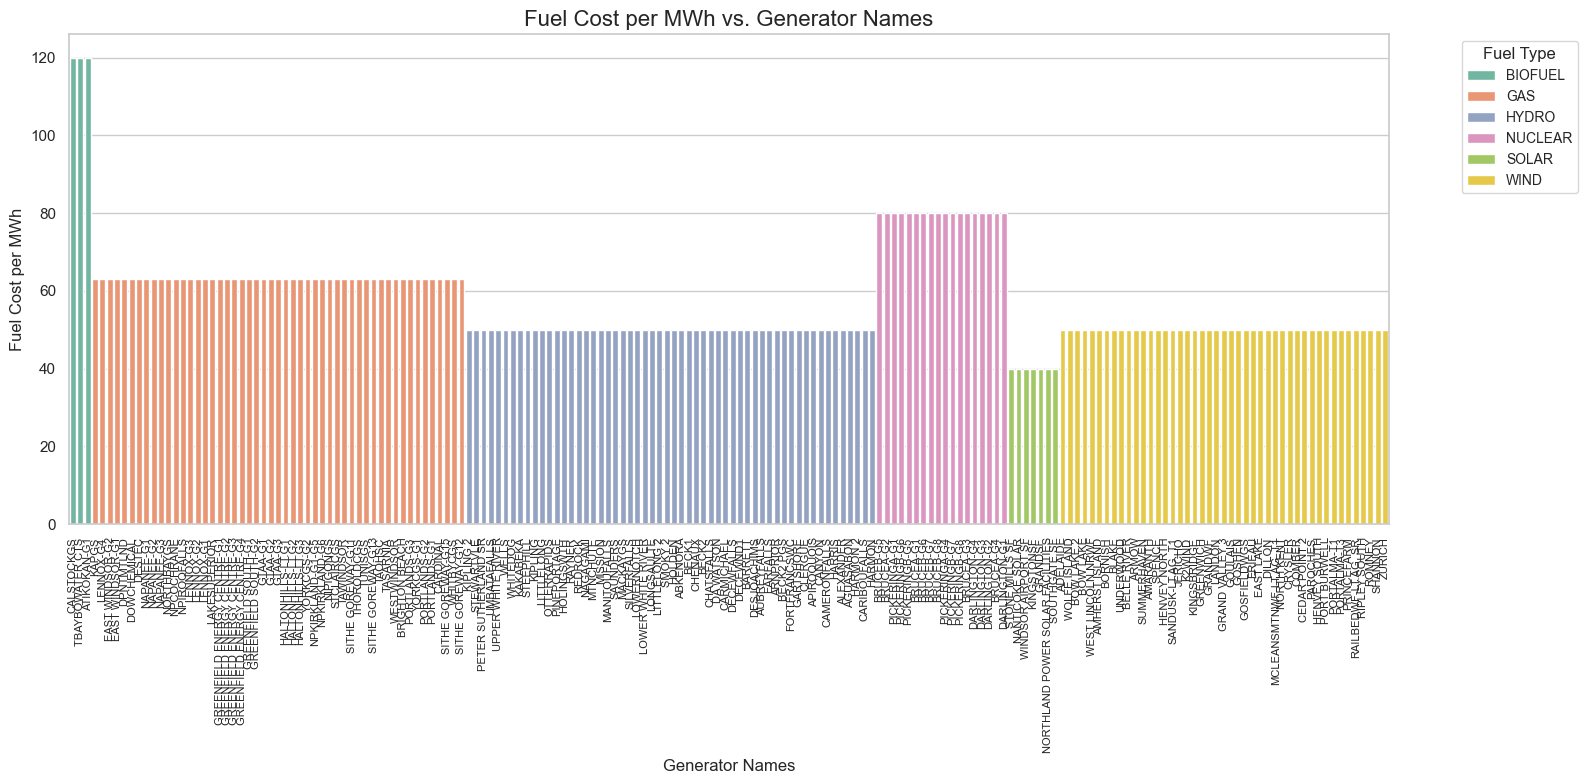

In [372]:
fuel_cost_df = pd.DataFrame.from_dict(fuel_cost_dict, orient='index', columns=['Fuel Cost'])
fuel_cost_df['Generator'] = fuel_cost_df.index
fuel_cost_df['Fuel Type'] = fuel_cost_df['Generator'].map(fuel_type_dict)  # Map the fuel type

fuel_cost_df = fuel_cost_df.sort_values(by='Fuel Type')

fuel_type_colors = sns.color_palette("Set2", n_colors=len(fuel_cost_df['Fuel Type'].unique()))

# Create the bar plot
plt.figure(figsize=(16, 8))

barplot = sns.barplot(
    data=fuel_cost_df,
    x='Generator',
    y='Fuel Cost',
    hue='Fuel Type',
    dodge=False,
    palette=fuel_type_colors
)

barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90, ha='center', fontsize=8)
plt.title('Fuel Cost per MWh vs. Generator Names', fontsize=16)
plt.xlabel('Generator Names', fontsize=12)
plt.ylabel('Fuel Cost per MWh', fontsize=12)
plt.legend(title='Fuel Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

**2. Operational Costs:** This measures the cost per hour of keeping a plant on

In [373]:
operational_costs = {
    'HYDRO': 5.61,
    'BIOFUEL': 11.21,
    'WIND': 1.4,
    'SOLAR': 1.4,
    'NUCLEAR': 26.19,
    'GAS': 7.4
}

operational_cost_dict = {generator: operational_costs[fuel_type] for generator, fuel_type in fuel_type_dict.items()}
print(operational_cost_dict, len(operational_cost_dict))

{'ABKENORA': 5.61, 'ADELAIDE': 1.4, 'AGUASABON': 5.61, 'ALEXANDER': 5.61, 'AMARANTH': 1.4, 'AMHERST ISLAND': 1.4, 'APIROQUOIS': 5.61, 'ARMOW': 1.4, 'ARNPRIOR': 5.61, 'ATIKOKAN-G1': 11.21, 'AUBREYFALLS': 5.61, 'BARRETT': 5.61, 'BECK1': 5.61, 'BECK2': 5.61, 'BECK2 PGS': 5.61, 'BELLE RIVER': 1.4, 'BLAKE': 1.4, 'BORNISH': 1.4, 'BOW LAKE': 1.4, 'BOW LAKE 2': 1.4, 'BRIGHTON BEACH': 7.4, 'BRUCEA-G1': 26.19, 'BRUCEA-G2': 26.19, 'BRUCEA-G3': 26.19, 'BRUCEA-G4': 26.19, 'BRUCEB-G5': 26.19, 'BRUCEB-G6': 26.19, 'BRUCEB-G7': 26.19, 'BRUCEB-G8': 26.19, 'CALSTOCKGS': 11.21, 'CAMERONFALLS': 5.61, 'CANYON': 5.61, 'CARDINAL': 7.4, 'CARIBOUFALLS': 5.61, 'CARMICHAEL': 5.61, 'CEDAR POINT 2': 1.4, 'CHATSFALLS': 5.61, 'CHENAUX': 5.61, 'CLERGUE': 5.61, 'COMBER': 1.4, 'CRYSLER': 1.4, 'DA WATSON': 5.61, 'DARLINGTON-G1': 26.19, 'DARLINGTON-G2': 26.19, 'DARLINGTON-G3': 26.19, 'DARLINGTON-G4': 26.19, 'DECEWFALLS': 5.61, 'DECEWND1': 5.61, 'DESJOACHIMS': 5.61, 'DESTEC': 7.4, 'DILLON': 1.4, 'DOWCHEMICAL': 7.4, 'DPNTMT

**3. Start-up and Shutdown Costs:**

Start-up and shutdown costs are crucial components in power generation optimization models as they help account for the operational realities of power plants. 

Start-up Costs: These are incurred when a power plant transitions from an "off" state to an "on" state. They can include fuel costs for initial firing, wear and tear during the start-up process, and labor costs. Incorporating start-up costs ensures that the model doesn't frequently switch a plant on and off, promoting operational stability and cost-efficiency.

Shutdown Costs: These are incurred when a plant transitions from an "on" state to an "off" state. While typically lower than start-up costs, they account for factors like cooling processes, safety checks, and minor maintenance required during shutdowns.

Including these costs ensures that the optimization model avoids excessive cycling of power plants, which could lead to inefficiencies, higher wear and tear, and additional maintenance costs. These costs will penalize whenever a plant is started up and shut down.

Aiming not to add more complexity to this project, we will assume that the start-up costs and the shutdown costs are the same. 

In [374]:
startup_costs = {
    'HYDRO': 10,
    'BIOFUEL': 120,
    'WIND': 10,
    'SOLAR': 10,
    'NUCLEAR': 0,
    'GAS': 120
}

generator_startup_cost = {gen: startup_costs[fuel_type] for gen, fuel_type in fuel_type_dict.items()}
print(generator_startup_cost, len(generator_startup_cost))

# Since the startup costs and shutdown costs are equivalent then we can duplicate the list
generator_shutdown_cost = generator_startup_cost.copy()
print(generator_shutdown_cost, len(generator_shutdown_cost))

{'ABKENORA': 10, 'ADELAIDE': 10, 'AGUASABON': 10, 'ALEXANDER': 10, 'AMARANTH': 10, 'AMHERST ISLAND': 10, 'APIROQUOIS': 10, 'ARMOW': 10, 'ARNPRIOR': 10, 'ATIKOKAN-G1': 120, 'AUBREYFALLS': 10, 'BARRETT': 10, 'BECK1': 10, 'BECK2': 10, 'BECK2 PGS': 10, 'BELLE RIVER': 10, 'BLAKE': 10, 'BORNISH': 10, 'BOW LAKE': 10, 'BOW LAKE 2': 10, 'BRIGHTON BEACH': 120, 'BRUCEA-G1': 0, 'BRUCEA-G2': 0, 'BRUCEA-G3': 0, 'BRUCEA-G4': 0, 'BRUCEB-G5': 0, 'BRUCEB-G6': 0, 'BRUCEB-G7': 0, 'BRUCEB-G8': 0, 'CALSTOCKGS': 120, 'CAMERONFALLS': 10, 'CANYON': 10, 'CARDINAL': 120, 'CARIBOUFALLS': 10, 'CARMICHAEL': 10, 'CEDAR POINT 2': 10, 'CHATSFALLS': 10, 'CHENAUX': 10, 'CLERGUE': 10, 'COMBER': 10, 'CRYSLER': 10, 'DA WATSON': 10, 'DARLINGTON-G1': 0, 'DARLINGTON-G2': 0, 'DARLINGTON-G3': 0, 'DARLINGTON-G4': 0, 'DECEWFALLS': 10, 'DECEWND1': 10, 'DESJOACHIMS': 10, 'DESTEC': 120, 'DILLON': 10, 'DOWCHEMICAL': 120, 'DPNTMTLND': 120, 'EARFALLS': 10, 'EAST LAKE': 10, 'EAST WINDSOR-G1': 120, 'EAST WINDSOR-G2': 120, 'ERIEAU': 10, '

4. **Health Costs in Power Generation:**

**Health costs** represent the societal and environmental impacts of air pollutants, such as particulate matter (PM), nitrogen oxides (NOₓ), sulfur dioxide (SO₂), and greenhouse gases (GHGs), emitted during electricity generation. These pollutants contribute to respiratory illnesses, cardiovascular diseases, and environmental degradation.

Importance of Incorporating Health Costs
1. **Promotes Sustainability**: By internalizing health costs, the model accounts for the broader societal impacts of power generation. This encourages the use of cleaner energy sources, aligning with sustainability goals.

2. **Encourages Informed Decision-Making**: Balances economic and environmental trade-offs, guiding policymakers toward reducing harmful emissions.

3. **Reflects True Costs**: Incorporating health costs highlights the hidden expenses of fossil fuels, supporting a transition to cleaner alternatives.

The following power plants present in **Ontario** incur health costs and will be considered in our model:
1. **Natural Gas Plants**: Emit **NOₓ** and **CO₂**, leading to moderate health impacts like smog formation and respiratory diseases.
2. **Biomass Plants**: Emit **PM**, **NOₓ**, and **CO₂**, depending on combustion efficiency, causing air quality degradation.

**Plants That Do Not Incur Health Costs**
1. **Nuclear Plants**: Do not burn fuel, so they emit no air pollutants during operation.
2. **Hydroelectric Plants**: Generate electricity without emissions, making them clean and health-neutral.
3. **Wind and Solar Plants**: Operate without burning fuels, producing zero emissions and no direct health costs.

By incorporating health costs, the model not only minimizes expenses but also aligns power generation with public health and environmental sustainability goals.


*Synthesizing Data:*

Unfortunately, we couldnt find a dataset containg the health costs of the gas and biofuel plants. Instead we logically synthesized the data.

To synthesize this dataset, we followed a logical and informed approach by consulting several authoritative resources to understand the health costs associated with power generation in Ontario. These included:

1. Cost Benefit Analysis: Replacing Ontario's Coal-Fired Electricity Generation by the Ontario Ministry of Energy, which provided insights into the health impacts of different fuel sources.
2. Air Pollution Impacts Report from the official site of Health Canada, which highlighted the relationship between fuel combustion and public health costs.
3. National Pollutant Release Inventory (NPRI) Data Search, offering emissions data for various fuel types.
4. Air Quality Benefits Assessment Tool (AQBAT), a model to estimate the health benefits of changes in air quality.

Using this foundational understanding, we synthesized logical cost data. Costs were assigned based on the generator's fuel type, with biofuel generators assigned higher health-related costs (ranging between 50 and 150) compared to gas generators (ranging between 30 and 100), reflecting their relative environmental and health impacts. The data was generated for 31 days and 24 hours per day, ensuring comprehensive coverage of operational periods.

We will use the health cost data for January 1, 2024 to align with our project's scope.

In [375]:
health_data = pd.read_csv("Power_Generator_Health_Costs_Dataset.csv")

# Filter data for January 1, 2024
data_filtered = health_data[(health_data['Year'] == 2024) & (health_data['Month'] == 1) & (health_data['Day'] == 1)]

# Dictionary with generator names and their corresponding health costs for 24 hours
generator_costs = {}
for generator in data_filtered['Generator'].unique():
    hourly_costs = data_filtered[data_filtered['Generator'] == generator]['Cost'].tolist()
    generator_costs[generator] = hourly_costs

for generator in unique_generators:
    if generator not in generator_costs:
        generator_costs[generator] = [0] * 24 # here for the generators that dont emit pollutants --> they dont incur health costs, i set a value of $0

df_gen_health = {}
for generator, costs in generator_costs.items():
    for hour, cost in enumerate(costs, start=1):
        df_gen_health[(generator, hour)] = cost

print(df_gen_health) # logically the length must be 180 * 24 hrs/ day = 4320 cost values. Each motor has 24 cost values
print(len(df_gen_health))


{('ATIKOKAN-G1', 1): 6.892591879, ('ATIKOKAN-G1', 2): 11.8886623, ('ATIKOKAN-G1', 3): 6.977198611, ('ATIKOKAN-G1', 4): 1.504513948, ('ATIKOKAN-G1', 5): 3.607897012, ('ATIKOKAN-G1', 6): 12.26908502, ('ATIKOKAN-G1', 7): 1.42137898, ('ATIKOKAN-G1', 8): 2.15220732, ('ATIKOKAN-G1', 9): 13.19040067, ('ATIKOKAN-G1', 10): 8.192912185, ('ATIKOKAN-G1', 11): 10.73280093, ('ATIKOKAN-G1', 12): 8.967185098, ('ATIKOKAN-G1', 13): 14.45320114, ('ATIKOKAN-G1', 14): 8.32009479, ('ATIKOKAN-G1', 15): 4.898197037, ('ATIKOKAN-G1', 16): 9.131489595, ('ATIKOKAN-G1', 17): 3.221044007, ('ATIKOKAN-G1', 18): 6.48738607, ('ATIKOKAN-G1', 19): 12.68067086, ('ATIKOKAN-G1', 20): 7.017196667, ('ATIKOKAN-G1', 21): 3.767437744, ('ATIKOKAN-G1', 22): 13.70571404, ('ATIKOKAN-G1', 23): 13.5335615, ('ATIKOKAN-G1', 24): 5.848151407, ('CALSTOCKGS', 1): 14.59080957, ('CALSTOCKGS', 2): 4.694571521, ('CALSTOCKGS', 3): 14.79966024, ('CALSTOCKGS', 4): 3.497313823, ('CALSTOCKGS', 5): 6.772631244, ('CALSTOCKGS', 6): 13.41180161, ('CALS

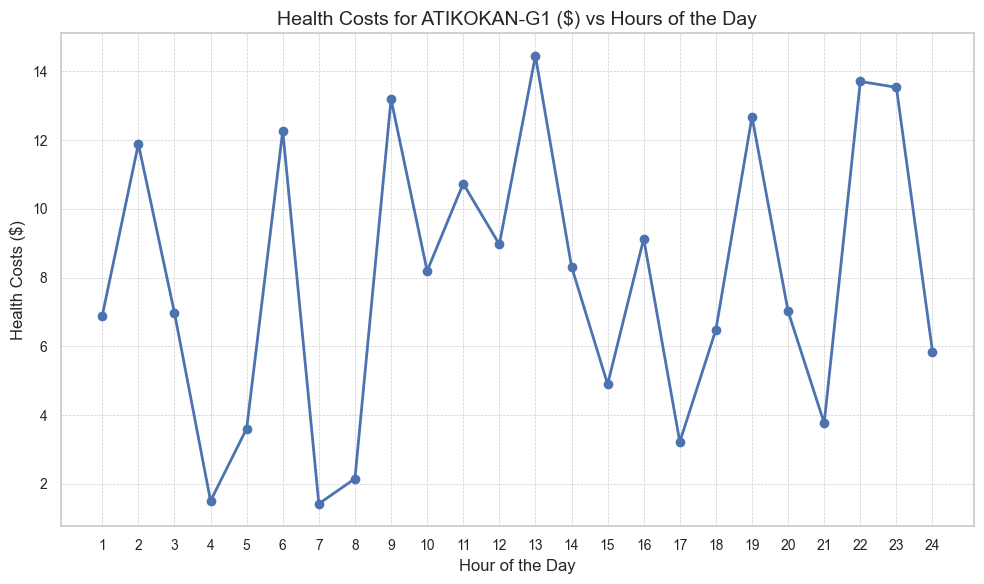

In [376]:
atikokan_costs = [df_gen_health[('ATIKOKAN-G1', hour)] for hour in range(1, 25)]

plt.figure(figsize=(10, 6))
plt.plot(range(1, 25), atikokan_costs, marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title("Health Costs for ATIKOKAN-G1 ($) vs Hours of the Day", fontsize=14)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Health Costs ($)", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(range(1, 25), fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# We can see that the health costs are the highest during the noon and after noon period of the day which is logical.

### **Optimization Model:**

This power generation optimization model offers a cutting-edge solution to a critical challenge in Ontario’s energy sector: balancing cost efficiency, sustainability, and operational reliability in power generation. With electricity demand fluctuating hourly, utilities often face inefficiencies, including over-reliance on expensive fuel sources, excessive cycling of power plants, and significant environmental and societal costs. Our model directly addresses these inefficiencies by leveraging mathematical optimization to minimize total costs across multiple dimensions: fuel, operational, startup, shutdown, and health costs. By incorporating real-world operational constraints—such as ramp-up/down limits and nuclear plant always-on requirements—the model ensures practical, feasible solutions tailored to Ontario’s energy infrastructure. Furthermore, with Ontario’s electricity grid aiming to phase out carbon-intensive sources and maximize the use of renewable energy, this model aligns with broader sustainability objectives outlined in Ontario’s **2021 Clean Energy Plan**. For stakeholders, implementing this model could mean millions in annual cost savings, reduced carbon footprints, and enhanced energy reliability. By optimizing resource allocation across power plants, this model addresses immediate cost concerns and also positions utilities to meet evolving regulatory demands, improve public health outcomes, and solidify their reputation as leaders in clean energy innovation.

## **Objective Function:**
The objective of our optimization model is to ***minimize*** the total cost of electricity generation over a 24-hour period, ensuring that energy demand is met for each hour while adhering to operational constraints for each generator.

The total cost consists of five components:
1. Fuel Costs: Cost of fuel used by each generator to produce power, which depends on the fuel type and the power generated.
2. Health Costs: Environmental and health-related costs due to emissions from generators that rely on polluting fuels (e.g., coal, gas).
3. Operational Costs: Fixed costs of keeping a generator online, regardless of its output.
4. Startup Costs: Costs incurred when transitioning a generator from an "off" state to an "on" state.
5. Shutdown Costs: Costs incurred when transitioning a generator from an "on" state to an "off" state.


In [377]:
model = gb.Model("OntarioPowerOptimizationProject")

## **Minimize:**
$$\quad \sum_{i \in G} \sum_{t \in T} \big( f_i \cdot p_{i,t} + e_{i,t} \cdot p_{i,t} + o_i \cdot x_{i,t} + l_i \cdot y_{i,t} + q_i \cdot z_{i,t} \big)$$

$\text{Where:}$

$\text{Sets:} \\$
- $G: \text{Set of all generators/ power plants} \\$
- $G_{N}: \text{Set of all nuclear generators} \\$
- $T: \text{Set of time periods (hours in a day)} \\$

$\text{Decision Variables:} \\$
- $p_{i,t}: \text{Power generated by generator } i \text{ during time period } t \text{ (in MWh)} \\$
- $x_{i,t}: \text{Binary variable indicating whether generator } i \text{ is online during time period } t \\$
- $y_{i,t}: \text{Binary variable indicating whether generator } i \text{ is started up in time period } t \\$
- $z_{i,t}: \text{Binary variable indicating whether generator } i \text{ is shut down in time period } t \\$

$\text{Parameters - Costs (\text{in CAD}):} \\$
- $f_i: \text{Fuel cost per MWh for generator } i \\$
- $e_{i,t}: \text{Health cost per MWh for generator } i \text{ during time period } t \\$
- $o_i: \text{Operational cost for generator } i \text{ (per hour when online)} \\$
- $l_i: \text{Startup cost for generator } i \\$
- $q_i: \text{Shutdown cost for generator } i$

$\text{Parameters - Others:} \\$
- $d_t$: power demand for each hour $t$,
- $c_i$: maximum power generation capability/ capacity for power plant $i$, 
- $m_i$: minimum % power that must be generated from power plant $i$, 
- $r_i$: ramp up/ramp down speed for power plant $i$.


In [378]:
G = unique_generators # list of all generators
T = hours

# Define the decision variables
p = model.addVars(
    G,
    T,
    name = "p",
    lb = 0,
    vtype = GRB.CONTINUOUS
)  # Power generated by each generator during each time period (in MWh)

x = model.addVars(
    G, 
    T, 
    name = "x", 
    vtype = GRB.BINARY
)  # Whether the generator is online during each time period

y = model.addVars(
    G, 
    T, 
    name = "y", 
    vtype = GRB.BINARY
)  # Whether the generator is started up during each time period

z = model.addVars(
    G, 
    T, 
    name = "z", 
    vtype = GRB.BINARY
)  # Whether the generator is shut down during each time period

model.update()

print("This model has", len(p) + len(x) + len(y) + len(z), "decision variables.") # For Debugging

This model has 17280 decision variables.


In [379]:
# Objective Function: Minimize total costs
health_costs = df_gen_health

objective = gb.quicksum(
    fuel_cost_dict[i] * p[i, t] +                             # Fuel costs
    health_costs.get((i, t), 0) * p[i, t] +                   # Health costs
    operational_cost_dict[i] * x[i, t] +                      # Operational costs
    generator_startup_cost[i] * y[i, t] +                     # Startup costs
    generator_shutdown_cost[i] * z[i, t]                      # Shutdown costs
    for i in G for t in T                                     # Summed over all generators and time periods
)

model.setObjective(objective, GRB.MINIMIZE)
# print(health_costs.get(('ATIKOKAN-G1', 1), 0)) # Debugging

$\textbf{Meet Demand Constraint:} \\$

The **Meet Demand** constraint ensures that the total power generated by all the generators in the system matches the power demand at each hour. This constraint is vital for ensuring that the system meets the electricity demand for each time period *t*. Mathematically, this constraint ensures that the sum of the power generated by all generators *i* at hour *t* equals the demand ${d_t}$ for that hour.


$$\sum_{i \in G} p_{i,t} = d_t \quad \forall t \in T$$

In [380]:
model.addConstrs(
    (gb.quicksum(p[i, t] for i in unique_generators) >= d[t] for t in H),
    name = "Meet Demand"
)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>,
 22: <gurobi.Constr *Awaiting Model Update*

$\textbf{Maximum and Minimum Generation Levels Constraints:} \\$

The Maximum and Minimum Generation Levels constraints ensure that each generator operates within its permissible range during each time period *t*. Specifically:

**Maximum Generation Constraint:**

The power generated $p_{i,t}$, by generator *i* during time period *t* cannot exceed its maximum capacity $c_i$. Furthermore, if the generator is off ($x_{i,t}$ = 0), the power generated must be zero. This is captured by:

$$p_{i,t} \leq c_i \cdot x_{i,t} \quad \forall i \in G, \, t \in T​$$
 
**Minimum Generation Constraint:**

Certain generators, such as nuclear plants, need to operate above a minimum threshold (e.g., 75% of capacity), while others might only require a much smaller threshold (e.g., 1%). This is captured by:

$$p_{i,t} \geq m_i \cdot c_i \cdot x_{i,t} \quad \forall i \in G, \, t \in T$$
​
Where $m_{i}$ is the minimum percentage of capacity required for generator *i* when it is turned on.

**Note that** this constraint also ensures that when there is no power generated, i.e., $p_{i,t} = 0$, then the plant is said to be turned "off", i.e., $x_{i,t} =0$.

In [381]:
for i in gen_capability_dict.keys():
    gen_capability_dict[i] = int(gen_capability_dict[i])

# Maximum generation constraint
model.addConstrs(
    (p[i, t] <= gen_capability_dict[i] * x[i, t] for i in unique_generators for t in H),
    name = "Max Generation"
)

# Minimum generation constraint
model.addConstrs(
    (p[i, t] >= m[i] * gen_capability_dict[i] * x[i, t] for i in unique_generators for t in H),
    name = "Min Generation"
)

{('MACKAYGS', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 17): <gurobi.Constr *Awaiting Model

$\textbf{Nuclear Plants Are Always On Constraint:} \\$

Nuclear power plants have unique operational characteristics. They cannot be frequently started up or shut down due to the high costs, long preparation times, and safety concerns associated with such operations. As a result, once operational, they are typically required to remain active and generate at least a minimum amount of power (e.g., 75% of their maximum capacity as discussed earlier).

To enforce this behavior in the model, we use the following constraint:
$$p_{i,t} \geq m_i \cdot c_i \quad \forall i \in G_N, \, t \in T$$

Incorporating this constraint reflects real-world operational limitations and improves the reliability of the optimization model. It ensures that the model does not unrealistically shut down nuclear plants for short-term cost savings, which would be infeasible in practice.

In [382]:
model.addConstrs(
    (p[i, t] >= m[i] * gen_capability_dict[i] for i in nuclear_generators for t in H),
    name = "Nuclear Always On"
)

{('DARLINGTON-G2', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('DARLINGTON-G2', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('DARLINGTON-G2', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('DARLINGTON-G2', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('DARLINGTON-G2', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('DARLINGTON-G2', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('DARLINGTON-G2', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('DARLINGTON-G2', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('DARLINGTON-G2', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('DARLINGTON-G2', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('DARLINGTON-G2', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('DARLINGTON-G2', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('DARLINGTON-G2', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('DARLINGTON-G2', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('DARLINGTON-G2', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('DARLINGTON-G2', 16): <gurobi.Co

$\textbf{Max Rampdown and Rampup Constraint:} \\$

Power plants are designed to gradually adjust their generation levels. Rapid changes, known as ramping up (increasing power generation) or ramping down (decreasing power generation), can cause stress to the plant's machinery, lead to inefficiencies, or even damage equipment. To account for this, we impose a constraint that limits the amount by which power generation can increase or decrease between successive hours.

The rampup and rampdown constraint ensures that the change in power output for a generator does not exceed a certain percentage of its maximum capability/ capacity ($c_i$), determined by its ramp rate ($r_i$). For a generator *i*, the change in power generation between hour *h* and *h − 1* is constrained by:
$$- r_i \cdot c_i \leq p_{i,h} - p_{i,h-1} \leq r_i \cdot c_i \quad \forall i \in G, \, h > 1$$

In [383]:
model.addConstrs(
    (p[i, h] - p[i, h-1] >= -r[i] * gen_capability_dict[i] for i in unique_generators for h in H if h > 1),
    name = "Ramp Down"
)

model.addConstrs(
    (p[i, h] - p[i, h-1] <= r[i] * gen_capability_dict[i] for i in unique_generators for h in H if h > 1),
    name = "Ramp Up"
)

{('MACKAYGS', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 18): <gurobi.Constr *Awaiting Mode

$\textbf{Logical Consistency of On/Off Transitions:} \\$
This constraint ensures that when a generator is switched "on" during a specific time period, it is actively online, and when it is switched "off," it is not online. This helps maintain the logical consistency of the model. Hence, the constraint ensures:
- If the generator is switched "on" ($y_{i,t}$ = 1), it must also be "on" ($x_{i,t}$ = 1).
- If the generator is switched "off" ($z_{i,t}$ = 1), it must also be "off" ($x_{i,t}$ = 0).

These constraints are linear inequalities expressed as the following for each generator $i$ and hour $t$,
$$y_{i,t} \leq x_{i,t}, \quad \forall i \in G, \, \forall t \in T$$
$$z_{i,t} \leq 1 - x_{i,t}, \quad \forall i \in G, \, \forall t \in T$$

In [384]:
model.addConstrs(
    (y[i, t] <= x[i, t] for i in G for t in T),
     name = "Start_Consistency"
)

model.addConstrs(
    (z[i, t] <= 1 - x[i, t] for i in G for t in T),
    name = "Shutdown_Consistency"
)

{('MACKAYGS', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 17): <gurobi.Constr *Awaiting Model

$\textbf{Linking Startup/ Shutdown Variables to "On"/ "Off" Variables:} \\$

This constraint links the startup ($y_{i,t}$) and shutdown ($z_{i,t}$) binary variables to the "on" ($x_{i,t}$) variable. It ensures consistency between the state of a generator in consecutive time periods. Specifically:
- If a generator is turned off at hour t−1 and turned on at hour t, the startup variable $y_{i,t}$ is set to 1.
- If a generator is turned on at hour t−1 and turned off at hour t, the shutdown variable $z_{i,t}$ is set to 1.
- If there is no change in the generator's state, both $y_{i,t}$ and $z_{i,t}$ are set to 0.

This constraint is crucial for modeling the operational dynamics of generators, ensuring that startups and shutdowns are correctly captured and penalized through their associated costs in the objective function.

All of these possible combinations can be expressed using the following equality constraint for each generator $i$ and hour $t>1$,
$$y_{i,t} - z_{i,t} = x_{i,t} - x_{i,t-1}, \quad \forall i \in G, \forall t > 1$$

In [385]:
model.addConstrs(
    (y[i, t] - z[i, t] == x[i, t] - x[i, t - 1])
    for i in unique_generators
    for t in H
    if t > 1
)

{('MACKAYGS', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('MACKAYGS', 18): <gurobi.Constr *Awaiting Mode

$\textbf{Carbon Emission Limit (Sustainability) Constraint:} \\$

This constraint ensures that the total carbon emissions from all generators across a 24-hour period in Ontario do not exceed the daily carbon cap, which is set to align with provincial and national climate commitments, such as those under the Paris Agreement. It incentivizes the use of low-emission generators and supports the transition toward a cleaner, more sustainable energy system.

Why This Constraint is Important:

1. Climate Goals Compliance:

* Ontario has committed to reducing emissions by 30% below 2005 levels by 2030, targeting a cap of approximately 57,534 tonnes of CO₂ per day for the electricity sector. (Ontario’s Environment Plan)
* Helps meet Canada’s national commitment of a 40-45% reduction by 2030. (Canada's National Commitment)

2. Promotes Cleaner Energy: By penalizing high-emission generators (e.g., gas plants) and favoring renewables (e.g., wind, hydro, solar), this constraint actively drives the optimization model toward sustainable solutions.

3. Operational Efficiency: Balances environmental goals with operational needs by carefully allocating emissions across power plants to avoid grid instability.

In [386]:
# Emission factors per fuel type (in tonnes CO2/MWh)
emission_factors_by_fuel = {
    'WIND': 0.011,  # in tonnes CO2/MWh
    'HYDRO': 0.024,
    'SOLAR': 0.045,
    'GAS': 0.450,
    'BIOFUEL': 0.050,
    'NUCLEAR': 0.012
}

generator_emission_factors = {gen: emission_factors_by_fuel[fuel_type_dict[gen]] for gen in unique_generators}
print(generator_emission_factors)

{'MACKAYGS': 0.024, 'ROMNEY': 0.011, 'PORTLANDS-G1': 0.45, 'KIPLING': 0.024, 'DECEWND1': 0.024, 'MCLEANSMTNWF-LT.AG_T1': 0.011, 'SITHE GOREWAY-G15': 0.45, 'RAILBEDWF-LT.AG_SR': 0.011, 'CEDAR POINT 2': 0.011, 'ALEXANDER': 0.024, 'BRUCEB-G8': 0.012, 'ATIKOKAN-G1': 0.05, 'EAST LAKE': 0.011, 'LOWER WHITE RIVER': 0.024, 'PICKERINGA-G1': 0.012, 'HARMON 2': 0.024, 'HENVEY NORTH': 0.011, 'PORTALMA-T1': 0.011, 'STCLAIRCGS': 0.45, 'OTTERRAPIDS': 0.024, 'HARRIS': 0.024, 'PICKERINGB-G5': 0.012, 'PINEPORTAGE': 0.024, 'BELLE RIVER': 0.011, 'NPKIRKLAND-G1-G5': 0.45, 'COMBER': 0.011, 'DILLON': 0.011, 'BRUCEA-G3': 0.012, 'YORKCGS-G1': 0.45, 'BRUCEA-G1': 0.012, 'KIPLING 2': 0.024, 'TBAYBOWATER CTS': 0.05, 'AGUASABON': 0.024, 'LOWERNOTCH': 0.024, 'MANITOUFALLS': 0.024, 'NORTHBAYGS': 0.45, 'NPIROQFALLS': 0.45, 'CARIBOUFALLS': 0.024, 'NANTICOKE SOLAR': 0.045, 'KINGSBRIDGE': 0.011, 'EAST WINDSOR-G2': 0.45, 'NORTHLAND POWER SOLAR FACILITIES': 0.045, 'TAWINDSOR': 0.45, 'TUNISGS': 0.45, 'BRUCEA-G4': 0.012, 'GR

**Computing the Carbon Cap:**
To compute the daily carbon cap for Ontario’s electricity sector, we followed these steps:

***Step 1:*** Identify Ontario's GHG Emission Targets
* Baseline Year: The Paris Agreement uses 2005 as the baseline year for emission reduction targets.
* Ontario’s 2005 Emissions: In 2005, Ontario's total greenhouse gas (GHG) emissions were approximately 200 Mt CO₂e. [Source: Ontario’s Environment Plan.]
* Target Reduction: Ontario aims to reduce emissions by 30% below 2005 levels by 2030.
$$Target Emissions=200×(1−0.30)=140Mt CO₂e/year$$
***Step 2:*** Isolate the Electricity Sector's Contribution
* The electricity sector contributes about 15% of Ontario’s total emissions. [Source: Ontario’s Environment Plan.]
* Target for the Electricity Sector:
$$Electricity Sector Cap (year)=140×0.15=21Mt CO₂e/year$$
***Step 3:*** Convert Annual Cap to a Daily Cap
There are 365 days in a year, so we divide the annual cap by 365 to compute the daily cap.
$$Daily Carbon Cap= 365×21≈ 57,534 tonnes CO₂/day$$
*Assumption*: The cap per day is a fixed amount


$$\sum_{i \in G} \sum_{t \in T} E_i \cdot p_{i,t} \leq \text{Carbon Cap}$$

$\textbf{Variables and Parameters:} \\$

$E_i : \text{Emission factor for generator } i \text{ (tonnes CO}_2\text{/MWh)} \\$
$p_{i,t} : \text{Power generated by generator } i \text{ at hour } t \text{ (MWh)} \\$
$\text{Carbon Cap} : \text{Maximum allowable daily carbon emissions (tonnes CO}_2\text{)} \\$


In [387]:
daily_carbon_cap = 57534  # in tonnes CO2

model.addConstr(
    gb.quicksum(generator_emission_factors[i] * p[i, t] for i in unique_generators for t in H) <= daily_carbon_cap,
    name="CarbonEmissionLimit"
)

<gurobi.Constr *Awaiting Model Update*>

$\textbf{Reserve Margin Requirement:} \\$

The **reserve margin** represents the extra power capacity above the expected peak demand that must be maintained to ensure the grid's reliability. This margin accounts for:

* Unexpected surges in demand (e.g., during extreme weather).
* Unplanned outages or failures of power plants.
* Grid reliability requirements as defined by regulatory authorities.

This constraint ensures that the total power generated by all plants at any given hour is greater than or equal to the hourly demand plus a reserve margin. The reserve margin acts as a buffer to guarantee a reliable electricity supply, even in adverse conditions.

How to strategically set the reserve margin in our case? --> *It will be done through benchmarks*

Common Industry Reserve Margins:
* North America: Typically 15% to 20% for most regions.
* Ontario: Based on historical practices and IESO guidelines, a 15% reserve margin is standard.

$$\sum_{i \in G} p_{i,t} \geq (1 + R) \cdot d_t \quad \forall t \in T$$

$\textbf{Variables and Parameters:} \\$

- $p_{i,t} : \text{Power generated by generator } i \text{ at hour } t \text{ (MWh)} \\$
- $d_t : \text{Power demand at hour } t \text{ (MWh)} \\$
- $R : \text{Reserve margin percentage (e.g., 0.15 for 15\%)} \\$

In [388]:
reserve_margin = 0.15  # 15%

model.addConstrs(
    (gb.quicksum(p[i, t] for i in unique_generators) >= (1 + reserve_margin) * d[t]
    for t in H),
    name = "ReserveMargin"
)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>,
 22: <gurobi.Constr *Awaiting Model Update*

In [389]:
# Optimization
model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 30181 rows, 17280 columns and 80592 nonzeros
Model fingerprint: 0x2021b01e
Variable types: 4320 continuous, 12960 integer (12960 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+04]
Presolve removed 9395 rows and 2498 columns
Presolve time: 0.19s
Presolved: 20786 rows, 14782 columns, 59364 nonzeros
Variable types: 3792 continuous, 10990 integer (10990 binary)
Found heuristic solution: objective 2.792334e+07
Found heuristic solution: objective 2.776652e+07

Root relaxation: objective 2.632179e+07, 4366 iterations, 0.07 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      | 

## **Optimal Power Schedule:**

Power Supply Curve for each generator for 24 hours.

Total number of used generators: 120


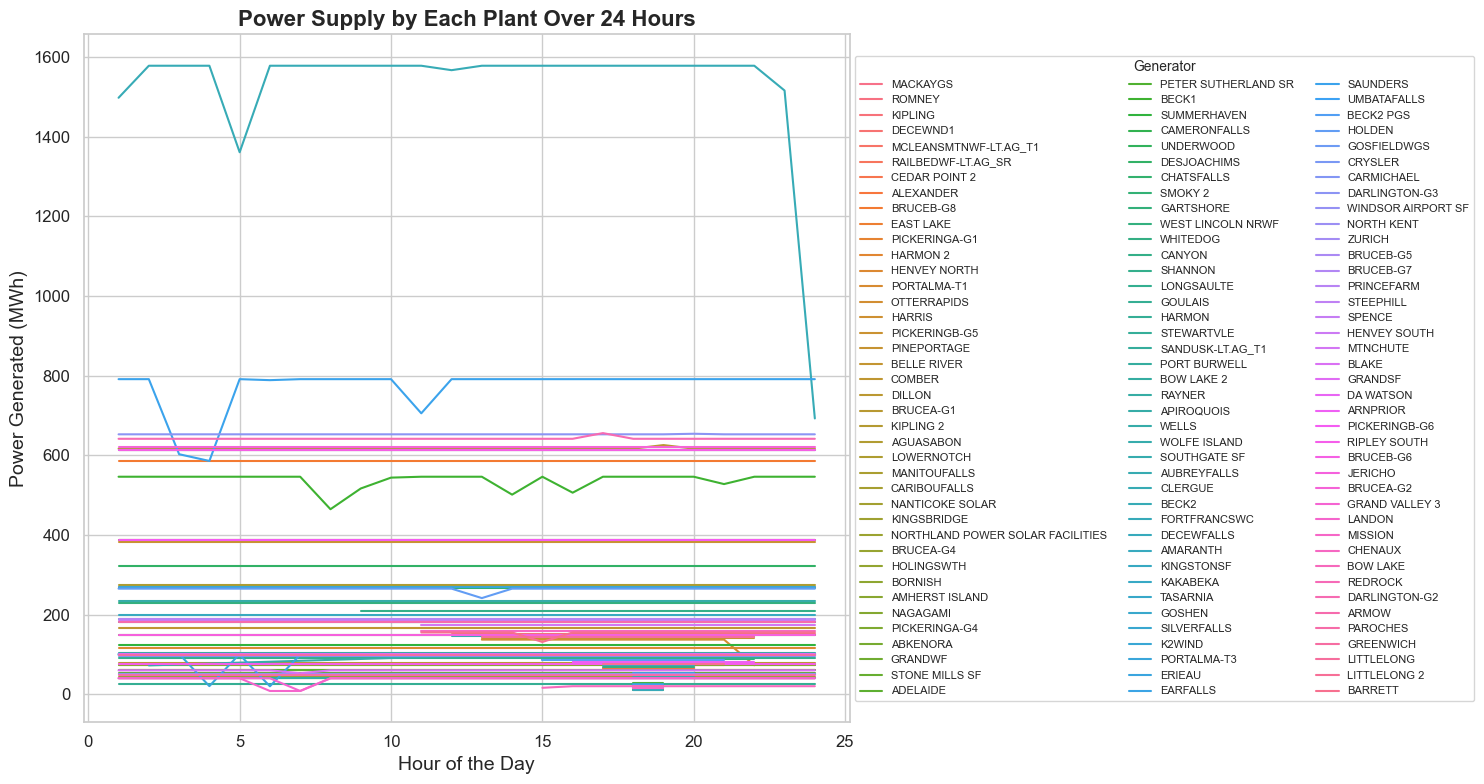

In [ ]:
# Create a DataFrame to store the power supply data
solution = pd.DataFrame(columns=['Hour', 'Power (MWh)', 'Plant'])

# Extract the plant-hour pairs with positive power generation
plant_hour_pairs = [(t, i) for i in unique_generators for t in H if p[i, t].X > 0]

# Populate the DataFrame
solution['Hour'] = [pair[0] for pair in plant_hour_pairs]  # Extract hours
solution['Plant'] = [pair[1] for pair in plant_hour_pairs]  # Extract plants
solution['Power generated (MWh)'] = [p[pair[1], pair[0]].X for pair in plant_hour_pairs]  # Extract power generated

# total number of unique plants that generated power in our project (out of 180)
#used_generators = solution['Plant'].nunique()
#print(f"Total number of used generators: {used_generators}")


plt.figure(figsize=(15, 8))
sns.lineplot(data=solution, x='Hour', y='Power generated (MWh)', hue='Plant', linewidth=1.5)
plt.title("Power Supply by Each Plant Over 24 Hours", fontsize=16, weight='bold')
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Power Generated (MWh)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Generator', fontsize=8, title_fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)
plt.tight_layout()
plt.show()

*Reporting the total number of used generators*

In [ ]:
renewable_fuel_types = {'HYDRO', 'WIND', 'SOLAR'}
non_renewable_fuel_types = {'NUCLEAR', 'GAS'}
solution['Fuel Type'] = solution['Plant'].map(fuel_type_dict)  # Map fuel types to each generator

used_generators = solution['Plant'].nunique()
renewable_generators = solution[solution['Fuel Type'].isin(renewable_fuel_types)]['Plant'].nunique()
non_renewable_generators = solution[solution['Fuel Type'].isin(non_renewable_fuel_types)]['Plant'].nunique()

print(f"Total number of used generators: {used_generators}")
print(f"Total number of used renewable generators: {renewable_generators}")
print(f"Total number of used non-renewable generators (Nuclear, Gas): {non_renewable_generators}")

Total number of used generators: 120
Total number of used renewable generators: 106
Total number of used non-renewable generators (Nuclear, Gas): 14


In [405]:
categories = ['Renewable Generators', 'Non-Renewable Generators']
values = [renewable_generators, non_renewable_generators]

category_details = {
    'Renewable Generators': list(solution[solution['Fuel Type'].isin(renewable_fuel_types)]['Plant'].unique()),
    'Non-Renewable Generators': list(solution[solution['Fuel Type'].isin(non_renewable_fuel_types)]['Plant'].unique())
}

details = [', '.join(category_details[cat]) for cat in categories]

pie_data = pd.DataFrame({
    'Category': categories,
    'Count': values,
    'Details': details
})

fig = px.pie(
    pie_data, 
    names='Category', 
    values='Count', 
    title="Percentage of Renewable vs Non-Renewable Generators Used",
    hover_data=['Details'],
    labels={'Details': 'Generators'}
)

fig.update_traces(hovertemplate="<b>%{label}</b><br>Count: %{value}<br>Details: %{customdata[0]}")

fig.update_layout(
    title_font_size=16,
    legend_title_text='Generator Types',
    legend=dict(font_size=12)
)
fig.show()

**Interactive** Power Supply Curve for each generator for 24 hours.

In [391]:
fig = px.line(solution, x='Hour', y='Power generated (MWh)', color='Plant',
              title="Power Supply by Each Plant Over 24 Hours")
fig.update_layout(
    legend=dict(title="Generators", font=dict(size=10)),
    xaxis_title="Hour of the Day",
    yaxis_title="Power Generated (MWh)",
    template="plotly_white"
)
fig.show()

It is hard to detect all of the power stations used per hour due to the large number of stations hence, the top 10 performing generators will be plotted.

*Plot for top 10 generators*

In [392]:
total_power_per_generator = solution.groupby('Plant')['Power generated (MWh)'].sum().sort_values(ascending=False)
top_generators = total_power_per_generator.head(10).index  # Top 10 generators

top_generators_data = solution[solution['Plant'].isin(top_generators)]

fig = px.line(
    top_generators_data,
    x='Hour',
    y='Power generated (MWh)',
    color='Plant',
    title="Power Supply by Top 10 Generators Over 24 Hours",
    labels={'Hour': 'Hour of the Day', 'Power generated (MWh)': 'Power Generated (MWh)', 'Plant': 'Generator'},
    hover_data={'Hour': True, 'Power generated (MWh)': True, 'Plant': True}  # Add hover information
)

fig.update_layout(
    legend=dict(title="Generators", font=dict(size=10), orientation="v"),
    xaxis_title="Hour of the Day",
    yaxis_title="Power Generated (MWh)",
    template="plotly_white"
)
fig.show()

*Top 10 and Worst 10 Power  Generators*

In [393]:
total_power_per_generator = solution.groupby('Plant')['Power generated (MWh)'].sum().sort_values()

top_generators = total_power_per_generator.tail(10).index  # Top 10 generators
bottom_generators = total_power_per_generator.head(10).index  # Bottom 10 generators

top_generators_data = solution[solution['Plant'].isin(top_generators)]
bottom_generators_data = solution[solution['Plant'].isin(bottom_generators)]

top_generators_data['Category'] = 'Top 10 Generators'
bottom_generators_data['Category'] = 'Bottom 10 Generators'

combined_data = pd.concat([top_generators_data, bottom_generators_data])

fig = px.line(
    combined_data,
    x='Hour',
    y='Power generated (MWh)',
    color='Plant',
    line_dash='Category',  # Different line styles for Top and Bottom generators
    title="Power Supply by Top and Bottom 10 Generators Over 24 Hours",
    labels={'Hour': 'Hour of the Day', 'Power generated (MWh)': 'Power Generated (MWh)', 'Plant': 'Generator'},
    hover_data={'Hour': True, 'Power generated (MWh)': True, 'Plant': True, 'Category': True}
)

fig.update_layout(
    legend=dict(title="Generators", font=dict(size=10), orientation="v"),
    xaxis_title="Hour of the Day",
    yaxis_title="Power Generated (MWh)",
    template="plotly_white"
)
fig.show()

C:\Users\User\AppData\Local\Temp\ipykernel_32208\2070641824.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_32208\2070641824.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [394]:
print(fuel_type_dict['KIPLING'])

HYDRO


Power Demand Curve in Ontario

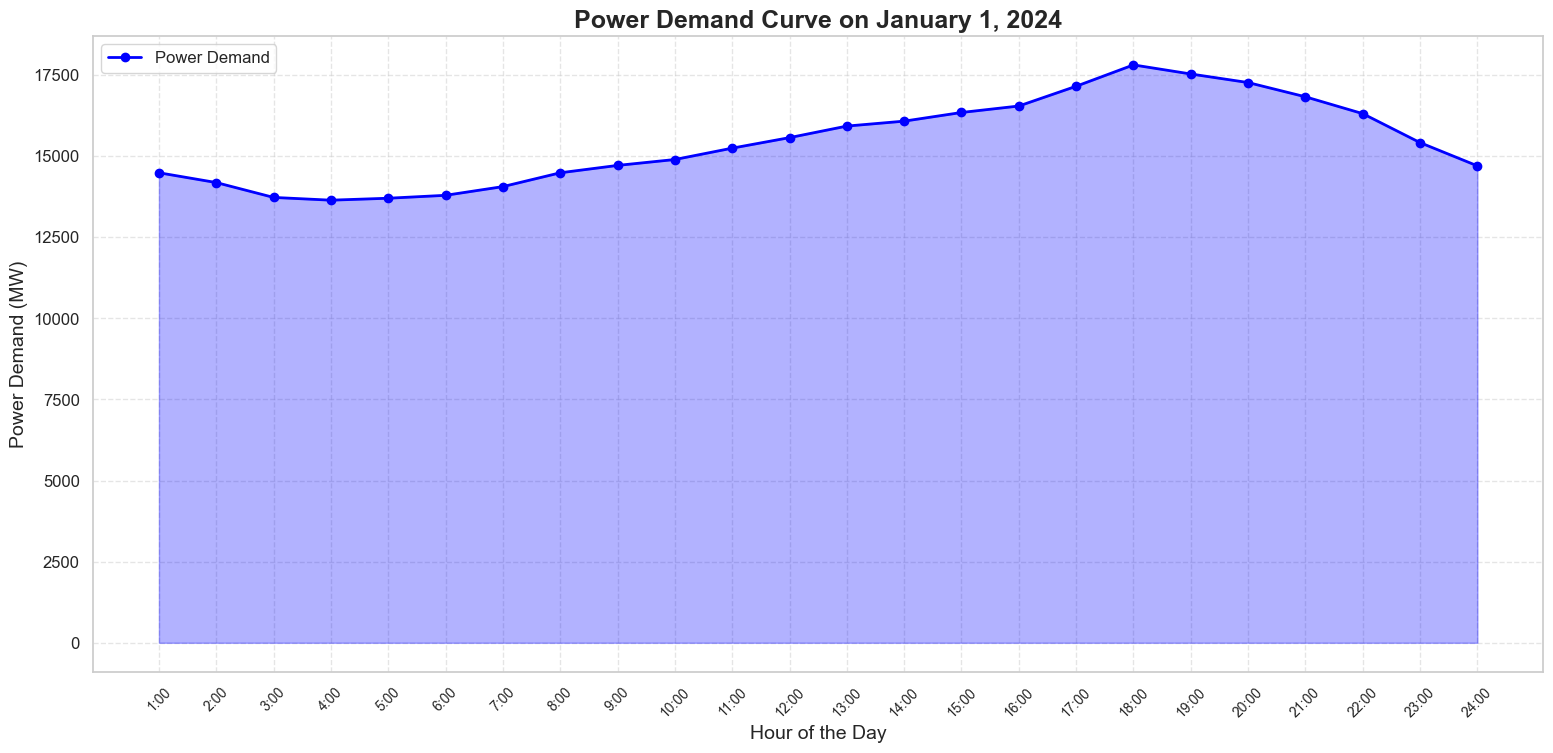

In [395]:
sns.set_theme(style="whitegrid")

hours = list(H)
demand = [d[h] for h in hours]

plt.figure(figsize=(16, 8))
plt.plot(hours, demand, marker='o', linestyle='-', linewidth=2, markersize=6, label='Power Demand', color='blue')
plt.fill_between(hours, demand, alpha=0.3, color='blue')  # Shaded area under the curve
plt.title('Power Demand Curve on January 1, 2024', fontsize=18, weight='bold')
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Power Demand (MW)', fontsize=14)
plt.xticks(ticks=hours, labels=[f'{h}:00' for h in hours], rotation=45, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12, loc="upper left")
plt.tight_layout(pad=2.0)
plt.show()

# **Printing the Results: Excel sheet showing the optimal power generation of the generators**

In [396]:
optimal_power_data = {
    'Generator': list(unique_generators)
}

for t in H:
    optimal_power_data[f'Hour {t}'] = [p[i, t].X if p[i, t].X > 0 else 0 for i in unique_generators]

optimal_power_df = pd.DataFrame(optimal_power_data)
output_file = "Optimal_Power_Generation.xlsx"
optimal_power_df.to_excel(output_file, index=False)

print(f"Optimal power generation data has been saved to {output_file}. Please check it for more information on the detailed power schedule.")

Optimal power generation data has been saved to Optimal_Power_Generation.xlsx. Please check it for more information on the detailed power schedule.


## **Short Analysis of the Results**

The optimal cost effective power schedule draws the bulk of power from Beck2 Hydro Generator and Saunders.

Also to match the fluctuation in power over the demand in 24 hours, some power plants provide fluctuations in power generation. This is evident in DECEWND1, Harris, and NAGAGAMI, all of which fall under the HYDRO category. For instance, DECEWND1 generator is "Turned ON" in hour 18 of the day and then "Turned Off" in hour 20 of the day. 

## **Reporting Optimal Costs**


In [397]:
fuel_cost_total = sum(fuel_cost_dict[i] * p[i, t].X for i in unique_generators for t in H)  # Fuel cost
health_cost_total = sum(health_costs[i, t] * p[i, t].X for i in unique_generators for t in H)  # Health cost
operating_cost_total = sum(operational_cost_dict[i] * x[i, t].X for i in unique_generators for t in H)  # Operating cost
startup_cost_total = sum(generator_startup_cost[i] * y[i, t].X for i in unique_generators for t in H)  # Startup cost
shutdown_cost_total = sum(generator_shutdown_cost[i] * z[i, t].X for i in unique_generators for t in H)  # Shutdown cost

total_cost = fuel_cost_total + health_cost_total + operating_cost_total + startup_cost_total + shutdown_cost_total

print("Optimal Costs Incurred:")
print("-"*30)
print(f"  1. Fuel Costs: ${fuel_cost_total:,.2f}")
print(f"  2. Health Costs: ${health_cost_total:,.2f}")
print(f"  3. Operating Costs: ${operating_cost_total:,.2f}")
print(f"  4. Startup Costs: ${startup_cost_total:,.2f}")
print(f"  5. Shutdown Costs: ${shutdown_cost_total:,.2f}")
print("-"*30)
print(f"Total Cost: ${total_cost:,.2f}")

Optimal Costs Incurred:
------------------------------
  1. Fuel Costs: $26,308,546.50
  2. Health Costs: $380.44
  3. Operating Costs: $12,402.73
  4. Startup Costs: $630.00
  5. Shutdown Costs: $560.00
------------------------------
Total Cost: $26,322,519.67


## **Results: Which Station to Turn On/ Off? At What Time?**

In [398]:
binary_status_rows = []

# Populate the list with rows
for generator in unique_generators:
    binary_status_row = {'Generator': generator}
    for hour in H:
        # Get the binary value of the generator being on/off
        binary_status_row[f'Hour {hour}'] = int(x[generator, hour].X)
    binary_status_rows.append(binary_status_row)

# Convert the list of rows into a DataFrame
binary_status_data = pd.DataFrame(binary_status_rows)

# Save to Excel
binary_status_excel_path = "Binary_Status_Optimal_Schedule.xlsx"
binary_status_data.to_excel(binary_status_excel_path, index=False)

print(f"Binary status data exported to: {binary_status_excel_path}")

Binary status data exported to: Binary_Status_Optimal_Schedule.xlsx


## **Sensitivity Analysis:**

**Sensitivity Analysis on Reserve Margin: Optimizing System Reliability and Cost Efficiency**:

We conducted sensitivity analysis on the reserve margin parameter to evaluate its impact on the total operational costs of power generation. The reserve margin, representing the additional capacity above the forecasted demand, ensures system reliability by providing a buffer for unexpected demand surges or generator outages.

This analysis is critical because:

1. Balancing Cost and Reliability: Increasing the reserve margin enhances system reliability but incurs higher operational costs due to underutilized or idle capacity. By analyzing the trade-offs, stakeholders can identify the optimal reserve margin to achieve reliability without unnecessary cost inflation.
2. Strategic Decision-Making: Understanding how varying reserve margins influence total costs equips policymakers and system operators with insights to set appropriate margins that align with Ontario’s reliability standards and economic goals.
3. Future Preparedness: With demand fluctuations and evolving energy markets, this analysis helps predict how reserve requirements might affect future costs, enabling proactive planning.

***Graphical Approach***

The graphical approach visually demonstrates how the total cost of the model (including operational, fuel, startup, shutdown, and health costs) changes with varying reserve margins. It provides an intuitive, high-level understanding of the trade-offs between reliability and cost-efficiency, making it ideal for stakeholder presentations and strategic decision-making.

In [399]:
# Define reserve margin scenarios (e.g., 10%, 15%, 20%, 25%)
reserve_margin_values = [0.05, 0.10, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]  # Different reserve margins to test
sensitivity_results = []

# Perform sensitivity analysis
for margin in reserve_margin_values:
    if "ReserveMargin" in [constr.ConstrName for constr in model.getConstrs()]:
        model.remove(model.getConstrByName("ReserveMargin"))
    
    model.addConstrs(
        (gb.quicksum(p[i, t] for i in unique_generators) >= (1 + margin) * d[t]
         for t in H),
        name="ReserveMargin"
    )
    

    model.optimize()
    
    total_cost = model.ObjVal  # Get the objective function value
    sensitivity_results.append({"Reserve Margin (%)": margin * 100, "Total Cost": total_cost})

sensitivity_df = pd.DataFrame(sensitivity_results)


fig = px.line(
    sensitivity_df,
    x="Reserve Margin (%)",
    y="Total Cost",
    title="Sensitivity Analysis: Reserve Margin Impact on Total Cost",
    markers=True,
    labels={"Reserve Margin (%)": "Reserve Margin (%)", "Total Cost": "Total Cost ($)"},
    template="plotly_white"
)
fig.update_traces(line=dict(width=3), marker=dict(size=10))
fig.update_layout(
    title=dict(font=dict(size=20, family="Arial", color="black"), x=0.5),
    xaxis=dict(title_font=dict(size=16), tickfont=dict(size=14)),
    yaxis=dict(title_font=dict(size=16), tickfont=dict(size=14)),
    legend=dict(font=dict(size=12), title_font=dict(size=14))
)

fig.show()


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 30205 rows, 17280 columns and 84912 nonzeros
Model fingerprint: 0xcbcf18fa
Variable types: 4320 continuous, 12960 integer (12960 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+04]

MIP start from previous solve produced solution with objective 2.63225e+07 (0.04s)
MIP start from previous solve produced solution with objective 2.63225e+07 (0.04s)
Loaded MIP start from previous solve with objective 2.63225e+07

Presolve removed 9419 rows and 2498 columns
Presolve time: 0.17s
Presolved: 20786 rows, 14782 columns, 59388 nonzeros
Variable types: 3792 continuous, 10990 integer (10990 binary)

Root relaxation: int

***Traditional Approach***

The traditional approach offers technical depth, analyzing the sensitivity of decision variables and constraints (e.g., shadow prices, slack, bounds). It reveals the underlying drivers of cost changes and identifies critical constraints, making it essential for model validation and fine-tuning.

In [400]:
# Temporarily relax the integer and binary constraints
for var in model.getVars():
    if var.VType in [GRB.BINARY, GRB.INTEGER]:
        var.VType = GRB.CONTINUOUS


model.optimize()

if model.status == GRB.OPTIMAL:
    print("Sensitivity Analysis (SA)\nOptimal Objective Value (Total Cost) =", model.objVal)

    decision_vars = []
    for var in model.getVars():
        decision_vars.append({
            "Variable": var.VarName,
            "Value (X)": var.X,
            "Objective Coeff (Obj)": var.Obj,
            "SAObjLow": var.SAObjLow,
            "SAObjUp": var.SAObjUp,
            "Reduced Cost (RC)": var.RC,
            "Lower Bound (LB)": var.LB,
            "SALBLow": var.SALBLow,
            "SALBUp": var.SALBUp,
            "Upper Bound (UB)": var.UB,
            "SAUBLow": var.SAUBLow,
            "SAUBUp": var.SAUBUp,
        })
    decision_vars_df = pd.DataFrame(decision_vars)

    constraints = []
    for constr in model.getConstrs():
        constraints.append({
            "Constraint Name": constr.ConstrName,
            "Sense": constr.Sense,
            "Slack": constr.Slack,
            "Shadow Price (Pi)": constr.Pi,
            "RHS": constr.RHS,
            "SARHSLow": constr.SARHSLow,
            "SARHSUp": constr.SARHSUp,
        })
    constraints_df = pd.DataFrame(constraints)

    with pd.ExcelWriter("Reserve_Sensitivity_Analysis_Results.xlsx") as writer:
        decision_vars_df.to_excel(writer, sheet_name="Decision Variables", index=False)
        constraints_df.to_excel(writer, sheet_name="Constraints", index=False)

    print("Sensitivity analysis results saved to 'Sensitivity_Analysis_Results.xlsx'.")
else:
    print('Optimization was stopped with status', model.status)

# Restore original variable types
for var in model.getVars():
    if var.VType == GRB.CONTINUOUS:  # Originally binary or integer
        var.VType = GRB.BINARY if "binary" in var.VarName else GRB.INTEGER

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 30421 rows, 17280 columns and 123792 nonzeros
Model fingerprint: 0xeaa7fd0d
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+04]
Presolve removed 9628 rows and 3432 columns
Presolve time: 0.06s
Presolved: 20793 rows, 17469 columns, 77607 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 AA' NZ     : 1.300e+05
 Factor NZ  : 2.780e+05 (roughly 14 MB of memory)
 Factor Ops : 5.301e+06 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual    